In [1]:
# Before starting import everything necessary

import h5py
import numpy as np
import os
import simplejson as json
import sys
import torch
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn as nn
import torch.nn.init as init
import torch.utils.data as data
import yaml

from torch.autograd import Variable

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from ssd.generator import CalorimeterJetDataset
from ssd.layers.modules import MultiBoxLoss
from ssd.net import build_ssd

In [40]:
# Set presentation settings
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as tick

from matplotlib import cm
from matplotlib.colors import SymLogNorm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

with open('../plots/palette.json') as json_file:
    color_palette = json.load(json_file)
plt.style.use('../plots/ssdjet.mplstyle')

In [39]:
plt.style.use('../plots/ssdjet.mplstyle')

In [9]:
DATA_SOURCE = '/eos/user/a/adpol/ceva/fast/'
CONFIG_FILE = '../ssd-config.yml'
CLASSES = ['b', 'W+H', 't']
THRESHOLD = 0.25

In [43]:
THRESHOLD = 0.25

In [4]:
config = yaml.safe_load(open(CONFIG_FILE))
ssd_settings = config['ssd_settings']
ssd_settings['n_classes'] += 1

In [6]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

net = build_ssd(0, config['ssd_settings'], True)
net.load_weights('../models/ssd-tp.pth')
net.eval()

SSD(
  (vgg): ModuleList(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=32)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=32)
    (6): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): PReLU(num_parameters=64)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): PReLU(num_parameters=64)
    (13): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (14): Conv2d(64, 

In [48]:
def plot_calo_image(pixels, gt=[], predictions=[], save_name=None):

    fig = plt.figure(figsize=(16, 6))

    height, width, offset = pixels.shape[2], pixels.shape[1], 15

    for index, calorimeter in enumerate(pixels):
        ax = plt.subplot(1, 2, index+1)
        ax = plt.gca()
        ax.set_xlim([-offset, width+offset])
        ax.set_xlabel('$\eta$', horizontalalignment='right', x=1.0)
        ax.set_xticks([0,170,340])
        ax.set_xticklabels([-3,0,3])
        ax.set_yticks([0,180,360])
        ax.set_yticklabels([-180,0,180])
        ax.set_ylim([-offset, height+offset])
        ax.set_ylabel('$\phi [\degree$]', horizontalalignment='right', y=1.0)
        
        # Show energy deposits
        im = ax.imshow(calorimeter.T,
                       norm=SymLogNorm(linthresh=0.03,
                                       vmin=0,
                                       vmax=pixels.max()),
                       interpolation='nearest')

        # Add scale
        cbar = fig.colorbar(im, extend='max', pad=0.05)
        cbar.set_label('$E_T$ [Normalized]', rotation=90, horizontalalignment='right', y=1.0)
    
        # Add ground truth
        for box in gt:
            xmin, ymin, xmax, ymax = box[0]*width, box[1]*height, box[2]*width, box[3]*height
            jet = patches.Rectangle((xmin, ymin),
                                    xmax-xmin,
                                    ymax-ymin,
                                    linewidth=2,
                                    edgecolor=color_palette['red']['shade_600'],
                                    facecolor='none')
            ax.add_patch(jet)
            ax.legend(['Ground Truth'], loc='lower left', bbox_to_anchor=(0., -0.14))
            ax.text(xmin, ymin,
                    '{}'.format(CLASSES[int(box[4])]),
                     weight='bold',
                     color='#FAFAFA',
                     size=14,
                     bbox={'facecolor': color_palette['red']['shade_900'], 'alpha': 1.0})

        # Draw the predicted boxes
        for box in predictions:
            xmin, ymin, xmax, ymax = box[2]*width, box[3]*height, box[4]*width, box[5]*height
            jet = plt.Rectangle((xmin, ymin),
                                xmax-xmin,
                                ymax-ymin,
                                linewidth=2,
                                edgecolor=color_palette['grey']['shade_500'],
                                facecolor='none')
            ax.add_patch(jet)
            ax.legend(['Prediction'], loc='lower left', bbox_to_anchor=(0., -0.14))
            ax.text(xmin, ymin,
                    '{0}: {1:.2f}'.format(CLASSES[int(box[0])], box[1]),
                    weight='bold',
                    color=color_palette['grey']['shade_100'],
                    size=14,
                    bbox={'facecolor': color_palette['grey']['shade_900'],
                          'alpha': 1.0})

        # Add CMS tag
        ax.text(0, 1.03, 'CMS',
                weight='bold',
                transform=ax.transAxes,
                color=color_palette['grey']['shade_900'],
                fontsize=14)

        # Add title
        if index:
            ax.set_title('HCAL $E_T$ with tagged jets', loc='right')
        else:
            ax.set_title('ECAL $E_T$ with tagged jets', loc='right')

    if save_name:
        fig.savefig(save_name)

    # Show plot
    plt.show();

In [12]:
from utils import get_data_loader
loader = get_data_loader('%s/RSGraviton_NARROW_2.h5' % DATA_SOURCE, 1, 0,
                         ssd_settings['input_dimensions'], ssd_settings['object_size'], return_pt=False,
                         qbits=None, shuffle=False)

In [22]:
batch_iterator = iter(loader)
image, target = next(batch_iterator)

<ipython-input-45-7cd7722ffc5f>:21: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm=SymLogNorm(linthresh=0.03,


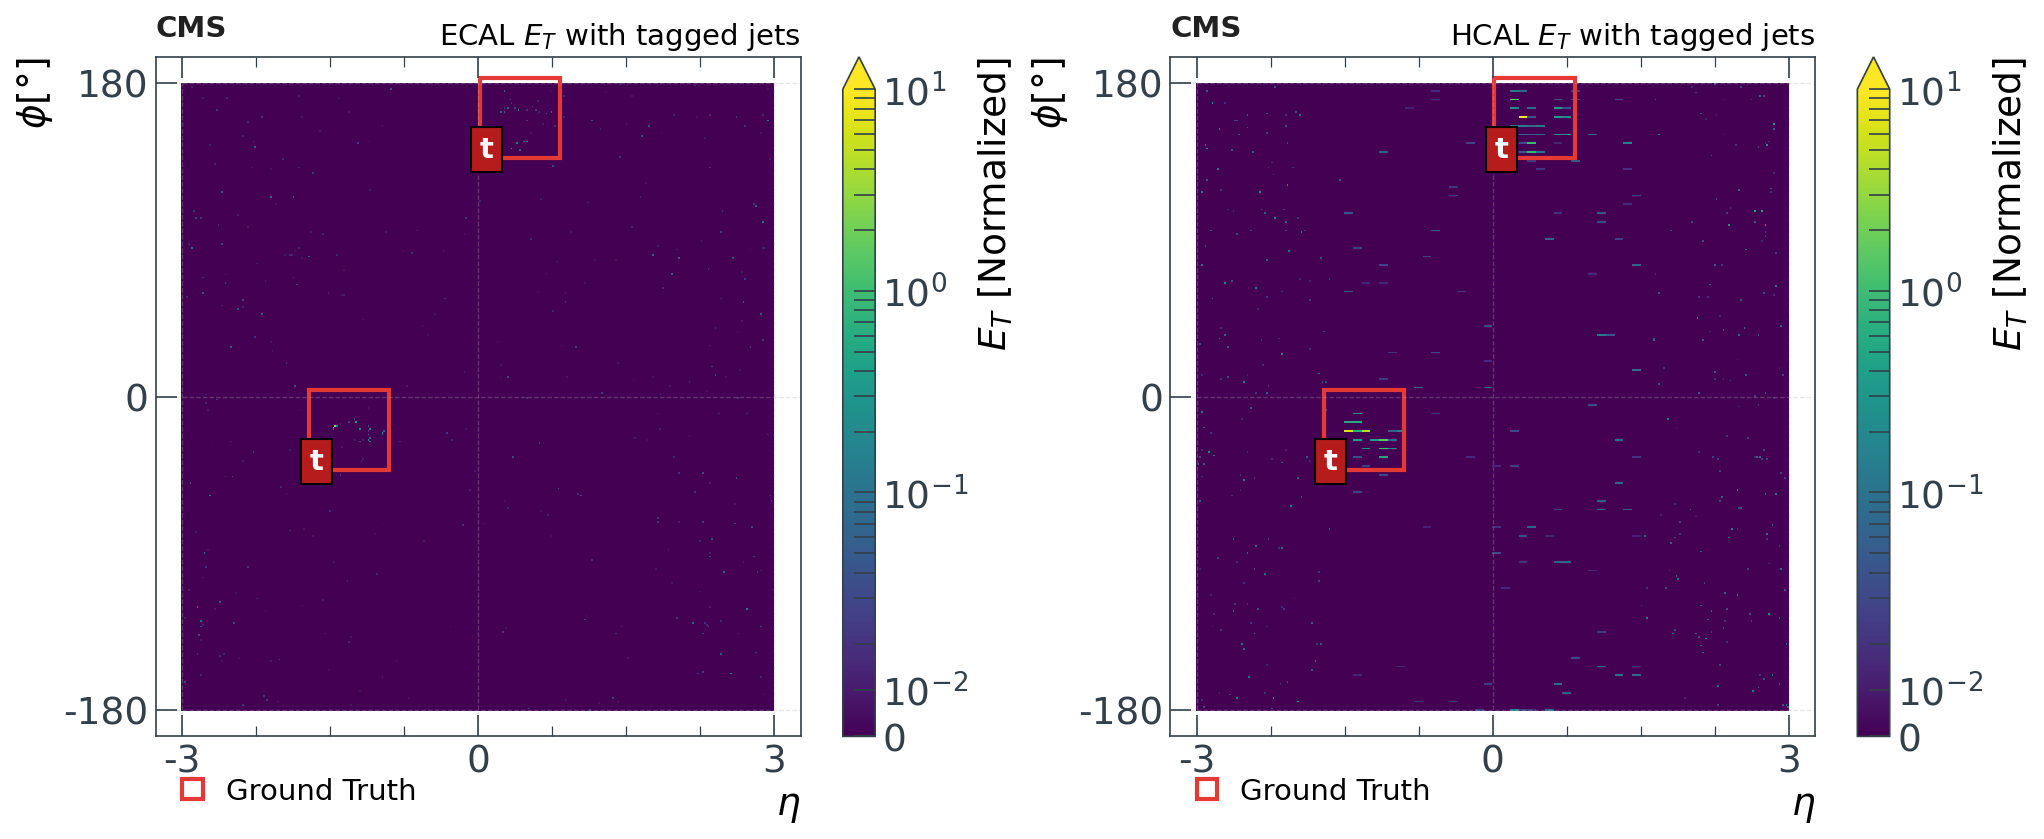

In [46]:
plot_calo_image(np.array(image[0].cpu()),
                np.array(target[0].cpu()),
                save_name='../plots/ssd-inference-example-gt')

<ipython-input-48-378845c97420>:21: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm=SymLogNorm(linthresh=0.03,


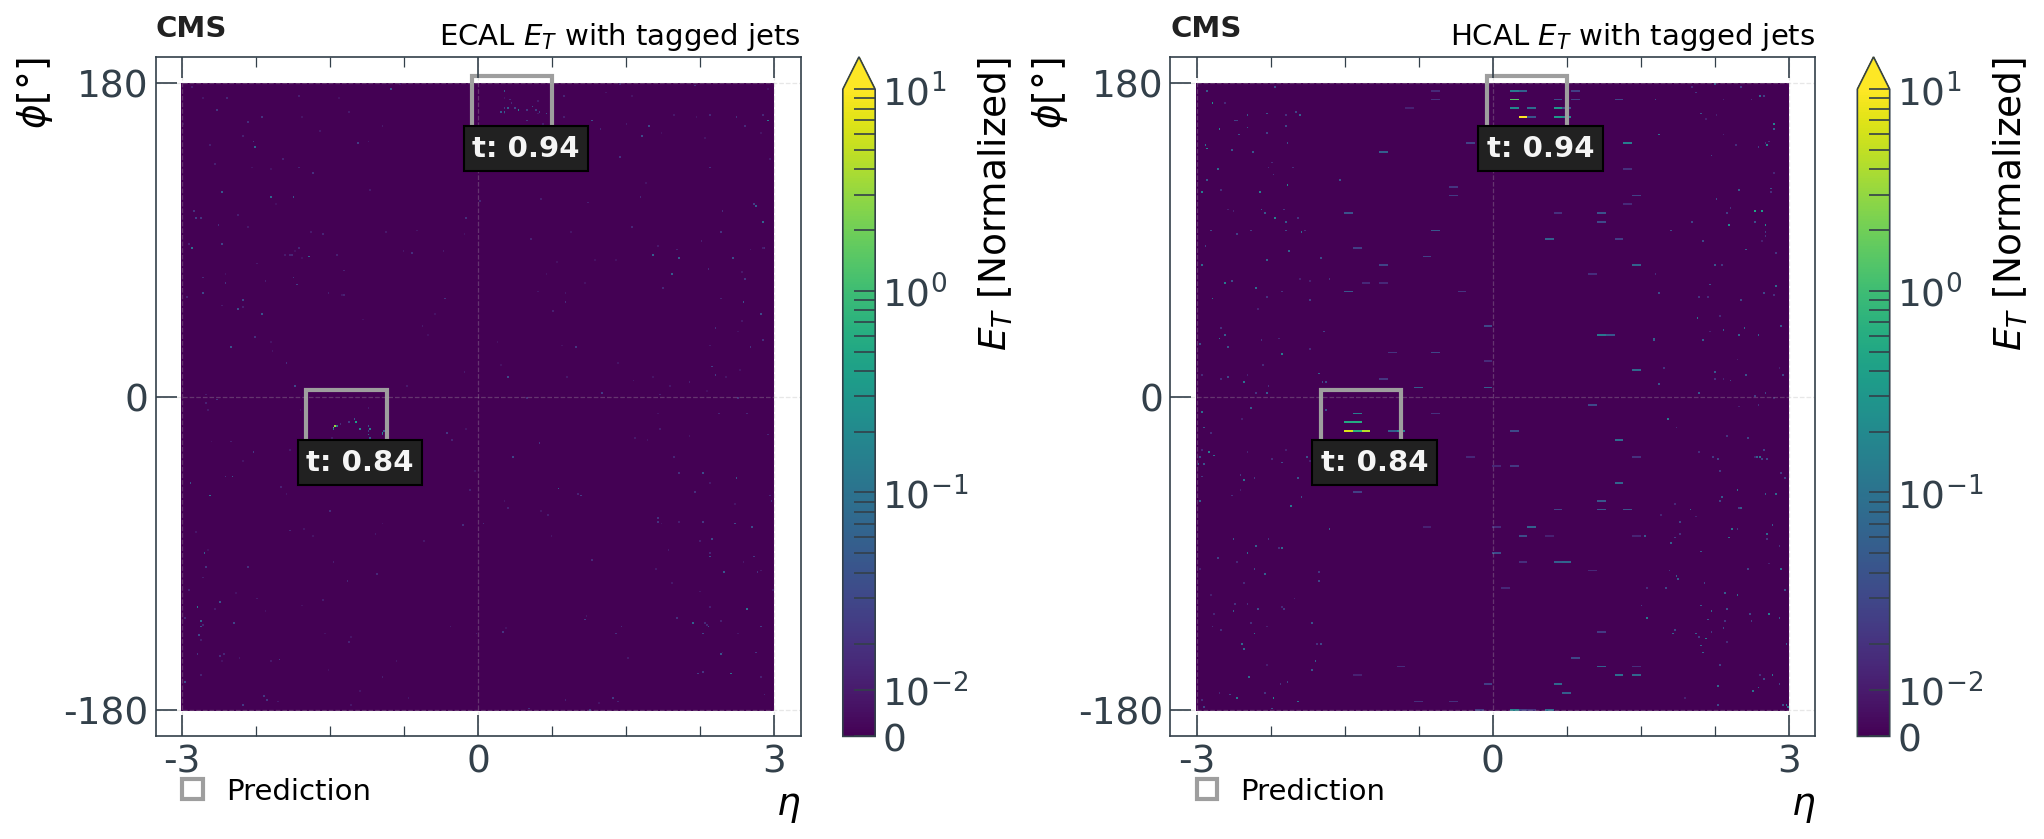

In [49]:
with torch.no_grad():
    detections = net(image).data.cpu().numpy()
    predictions = np.empty((0, 6))

    for cl, det in enumerate(detections[0]):
        columns = det.shape[1]
        mask = det[:, 0] >= THRESHOLD
        det = det.flatten()[np.repeat(mask, columns)]
        if len(det):
            det = det.reshape(-1, columns)
            cls = np.transpose(np.expand_dims(np.repeat(cl-1, det.shape[0]), 0))
            det = np.hstack((cls, det[:, :5]))
            predictions = np.vstack([predictions, det])

plot_calo_image(image.cpu().numpy()[0],
                predictions=predictions,
                save_name='../plots/ssd-inference-example-pred')